# **NST with Adaptive Instance Normalization** | Training

Project for *Neural Networks and Deep Learning*, University of Padua, A.Y. 2022/23

**Students** | Francesco Pio Barone, Daniele Ninni, Paolo Zinesi

In [1]:
import os
import glob
from PIL import Image
import inspect
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, RandomCrop, ToTensor

import huang_utils

In [2]:
# reproducibility
torch.manual_seed(0)

In [3]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Selected device: {device}')

Selected device: cuda


### 1 - Dataset

#### 1.1 - Download the datasets

In [4]:
content_name = 'pascal_voc'
style_name   = 'artbench'

if content_name == 'huang_content':
    content_path = f'./data/{content_name}/'
    if not os.path.exists('./data/huang_content'):
        !git clone https://github.com/xunhuang1995/AdaIN-style.git
        !mv AdaIN-style/input/content data
        !rm -r AdaIN-style
        !mv data/content data/huang_content
    
if style_name == 'huang_style':
    style_path = f'./data/{style_name}/'
    if not os.path.exists('./data/huang_style'):
        !git clone https://github.com/xunhuang1995/AdaIN-style.git
        !mv AdaIN-style/input/style data
        !rm -r AdaIN-style
        !mv data/style data/huang_style

if content_name == 'pascal_voc':
    content_path = f'./data/{content_name}/'
    if not os.path.exists('./data/pascal_voc'):
        !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
        !tar -xf VOCtrainval_11-May-2012.tar
        !mv VOCdevkit/VOC2012/JPEGImages data
        !rm -r VOCtrainval_11-May-2012.tar VOCdevkit
        !mv data/JPEGImages data/pascal_voc

if style_name == 'artbench':
    style_path = f'./data/{style_name}/**/*.jpg'
    if not os.path.exists('./data/artbench'):
        !wget https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder.tar
        !tar -xf artbench-10-imagefolder.tar
        !mv artbench-10-imagefolder data
        !rm -r artbench-10-imagefolder.tar
        !mv data/artbench-10-imagefolder data/artbench

#### 1.2 - Define the dataset transform

In [5]:
train_transform = Compose([
    Resize(512),
    RandomCrop(256),
    ToTensor()
])

#### 1.3 - Define the `ImageDataset` class

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.paths = glob.glob(f'{root}*')
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

#### 1.4 - Define the datasets

In [7]:
content_dataset = ImageDataset(content_path, train_transform)
style_dataset   = ImageDataset(style_path,   train_transform)

#### 1.5 - Define the dataloaders

In [8]:
batch_size = 32
content_dataloader = DataLoader(content_dataset, batch_size, shuffle=True, num_workers=os.cpu_count(), drop_last=True)
style_dataloader   = DataLoader(style_dataset,   batch_size, shuffle=True, num_workers=os.cpu_count(), drop_last=True)

# iterators
content_iter = iter(content_dataloader)
style_iter   = iter(style_dataloader)

### 2 - Architecture

#### 2.1 - Encoder

In [9]:
huang_utils.build_encoder()

Sequential(
  (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (1): ReflectionPad2d((1, 1, 1, 1))
  (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): ReflectionPad2d((1, 1, 1, 1))
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): ReflectionPad2d((1, 1, 1, 1))
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): ReflectionPad2d((1, 1, 1, 1))
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): ReflectionPad2d((1, 1, 1, 1))
  (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (17): ReLU()
  (18): ReflectionPad2d((1, 1, 1, 1))
  (19): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (20): ReLU()
  (21): ReflectionPad2d((1, 1, 1, 1))
  (22): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (23)

#### 2.2 - Decoder

In [10]:
huang_utils.build_decoder()

Sequential(
  (0): ReflectionPad2d((1, 1, 1, 1))
  (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (2): ReLU()
  (3): Upsample(scale_factor=2.0, mode=nearest)
  (4): ReflectionPad2d((1, 1, 1, 1))
  (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): ReflectionPad2d((1, 1, 1, 1))
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): ReflectionPad2d((1, 1, 1, 1))
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (12): ReLU()
  (13): ReflectionPad2d((1, 1, 1, 1))
  (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (15): ReLU()
  (16): Upsample(scale_factor=2.0, mode=nearest)
  (17): ReflectionPad2d((1, 1, 1, 1))
  (18): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (19): ReLU()
  (20): ReflectionPad2d((1, 1, 1, 1))
  (21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (22): ReLU()
  (23): Upsample(scale_factor=2.0, mode=nearest)
  (24): ReflectionPad2d((1, 1, 1, 1))
  (25): Conv2d(64, 64, 

#### 2.3 - Adaptive Instance Normalization layer `AdaIN`

In [11]:
print(inspect.getsource(huang_utils.get_mean_std))
print(inspect.getsource(huang_utils.AdaIN))

def get_mean_std(tensor, eps=1e-5):
    
    assert len(tensor.size()) == 4
    
    mean = torch.mean(tensor, dim=[2,3], keepdim=True)
    var  = torch.std(tensor, dim=[2,3], keepdim=True) + eps
    std  = torch.sqrt(var)

    return mean, std

class AdaIN(nn.Module):
    """ Implementation of Adaptive Instance Normalization (AdaIN) layer as described in the paper [Huang17]."""
    
    def __init__(self):
        super().__init__()

    def forward(self, content, style):
        content_mean, content_std = get_mean_std(content)
        style_mean,   style_std   = get_mean_std(style)
        return style_std * (content - content_mean) / content_std + style_mean



#### 2.4 - Define the `HuangNet_train` class

In [12]:
class HuangNet_train(nn.Module):

    def __init__(self, encoder, decoder, loss_fn=nn.MSELoss(), style_weight=1e-1):

        super(HuangNet_train, self).__init__()

        # encoder
        self.encoder = encoder
        
        # decoder
        self.decoder = decoder
        
        # AdaIN layer
        self.adain = huang_utils.AdaIN()

        # loss function
        self.loss_fn = loss_fn
        
        # style loss weight
        self.style_weight = style_weight
        
        # content loss history
        self.loss_content_hist = []
        
        # style loss history
        self.loss_style_hist = []
            
        # indexes of the encoder blocks
        self.encoder_blocks = [
            ( 0, 4), # input   -> relu1_1
            ( 4,11), # relu1_1 -> relu2_1
            (11,18), # relu2_1 -> relu3_1
            (18,31)  # relu3_1 -> relu4_1
        ]
        
        # freeze the encoder                
        for params in self.encoder.parameters():
            params.requires_grad = False

    # get [relu1_1, relu2_1, relu3_1, relu4_1]
    def get_intermediate_feats(self, input):
        results = [input]
        for (i,j) in self.encoder_blocks:
            results.append(self.encoder[i:j](results[-1]))
        return results[1:]

    # get content loss
    def get_loss_content(self, input, target):
        return self.loss_fn(input, target)

    # get style loss
    def get_loss_style(self, inputs, targets):
        loss_style = 0
        for input, target in zip(inputs, targets):
            input_mean,  input_std  = huang_utils.get_mean_std(input)
            target_mean, target_std = huang_utils.get_mean_std(target)
            loss_style += self.loss_fn(input_mean, target_mean) + self.loss_fn(input_std, target_std)
        return loss_style
        
    # forward pass
    def forward(self, content, style):
        
        # content feature maps
        content_feat = self.encoder(content)
        
        # style feature maps
        style_feats = self.get_intermediate_feats(style)
        
        # target feature maps
        t = self.adain(content_feat, style_feats[-1])
        
        # stylized image
        T = self.decoder(t)
        
        # stylized image feature maps
        T_feats = self.get_intermediate_feats(T)
        
        # content loss
        loss_content = self.get_loss_content(T_feats[-1], t)
        self.loss_content_hist.append(loss_content.item())

        # style loss
        loss_style = self.get_loss_style(T_feats, style_feats)
        self.loss_style_hist.append(loss_style.item())

        # total loss
        loss_total = loss_content + self.style_weight * loss_style
        
        return loss_total, loss_content, loss_style

### 3 - Training

#### 3.1 - Initialize the network

In [13]:
encoder = huang_utils.build_encoder('vgg_normalised.pth')
decoder = huang_utils.build_decoder()

style_weight = 1e-1

network = HuangNet_train(encoder, decoder, style_weight=style_weight)

#### 3.2 - Training settings

In [14]:
# number of iterations
n_iter = 1000

# learning rate
lr = 1e-4

# optimizer
optimizer = torch.optim.Adam(network.decoder.parameters(), lr=lr, betas=(0.9, 0.9))

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=100)

# move the network to the selected device
network.to(device);

#### 3.3 - Training loop

In [15]:
# set train mode for the network
network.train()

# training loop
with tqdm(total=n_iter, desc='NST-AdaIN Training') as pbar:
    
    for i in range(n_iter):
        
        try:
            content_batch = next(content_iter)
        except StopIteration:
            content_iter  = iter(content_dataloader)
            content_batch = next(content_iter)
        
        try:
            style_batch = next(style_iter)
        except StopIteration:
            style_iter  = iter(style_dataloader)
            style_batch = next(style_iter)
        
        # move images to the proper device
        content_batch = content_batch.to(device)
        style_batch   = style_batch.to(device)
        
        # evaluate loss
        loss_total, loss_content, loss_style = network(content_batch, style_batch)

        # backward pass
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
        scheduler.step(loss_total)

        # progress bar update
        pbar.update()
        pbar.set_postfix({'content loss': loss_content.item(), 'style loss': loss_style.item(), 'learning rate': scheduler._last_lr[0]})

# save decoder parameters
torch.save(decoder.state_dict(), f'decoder_b{batch_size}.pth')

NST-AdaIN Training: 100%|██████████| 1000/1000 [10:56<00:00,  1.52it/s, content loss=0.558, style loss=0.528, learning rate=1e-5] 


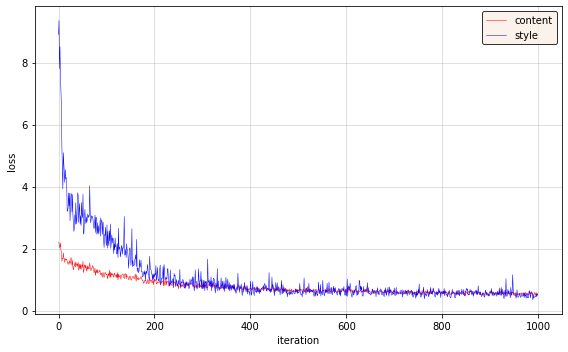

In [16]:
_, ax = plt.subplots(figsize=(8,5))
ax.plot(network.loss_content_hist, label='content', color='red',  linewidth=.5)
ax.plot(network.loss_style_hist,   label='style',   color='blue', linewidth=.5)
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.grid(alpha=.5)
ax.legend(edgecolor='black', facecolor='linen')
plt.tight_layout()
plt.show()
#plt.savefig(f'huang_train_b{batch_size}.pdf')

## **References**
- [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization](https://openaccess.thecvf.com/content_ICCV_2017/papers/Huang_Arbitrary_Style_Transfer_ICCV_2017_paper.pdf) | Paper
- [Neural Transfer Using PyTorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) | PyTorch
- [Neural Style Transfer with AdaIN](https://keras.io/examples/generative/adain) | Keras
- [AdaIN-style](https://github.com/xunhuang1995/AdaIN-style) | GitHub

***
Code by *Daniele Ninni*, last review: 10 February 2023, at 14:30